### Climate skill at 1&deg;: ENSO correlation coefficients

In [1]:
from collections import namedtuple

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from cartopy import crs as ccrs

from utils import get_beaker_dataset_variables, get_scalar_metrics
from constants import INFERENCE_COMPARISON_1DEG, SECONDS_PER_DAY, WANDB_ENTITY, WANDB_PROJECT

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rc('font', size=8)

In [76]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor"))

EVAL_VARS = [
    EvalVar("ULWRFtoa", "outgoing longwave radiation", "W/m^2", None),
#     EvalVar("TMP2m", "2-meter temperature", "K", None),
    EvalVar("PRATEsfc", "surface precipitation", "mm", SECONDS_PER_DAY),
]
DS_VARS = [var.name for var in EVAL_VARS]
SCALAR_METRIC_NAMES = [f'inference/enso_coefficient/rmse/{varname}' for varname in DS_VARS]

In [83]:
datasets = []
metrics = {}
api = wandb.Api()
for duration_name, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for group_name, group_runs in duration_runs.items():
        if isinstance(group_runs, dict):
            for ic_name, ic_run in group_runs.items():
                full_key = '/'.join([duration_name, group_name, ic_name])
                print(f"Getting dataset for run: {full_key=}")
                ic_dataset = get_beaker_dataset_variables(ic_run, 'enso_coefficient_diagnostics.nc', DS_VARS)
                for var in EVAL_VARS:
                    if var.conversion_factor is not None:
                        ic_dataset[var.name] = var.conversion_factor * ic_dataset[var.name]
                datasets.append(
                    ic_dataset
                    .expand_dims({'duration': [duration_name], 'group': [group_name], 'IC': [ic_name]})
                )
                print(f"Getting scalar metrics for run: {full_key=}")
                metrics[full_key] = get_scalar_metrics(
                    api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{ic_run}"),
                    SCALAR_METRIC_NAMES
                )
        else:
            full_key = '/'.join([duration_name, group_name])
            print(f"Getting run: {full_key=}")
            group_dataset = get_beaker_dataset_variables(group_runs, 'enso_coefficient_diagnostics.nc', DS_VARS)
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    group_dataset[var.name] = var.conversion_factor * group_dataset[var.name]
            datasets.append(
                group_dataset
                .expand_dims({'duration': [duration_name], 'group': [group_name]})
            )
enso_coefficient_ds = xr.merge(datasets).squeeze()

Downloading ⠼ 0:00:01 62.9 MB/s 24.7 MB

Getting scalar metrics for run: full_key='81yr/ACE-climSST/IC2'


In [84]:
metrics

{'10yr/ACE2-SHiELD/IC0': {'inference/enso_coefficient/rmse/ULWRFtoa': 3.341320514678955,
  'inference/enso_coefficient/rmse/PRATEsfc': 7.5639813985617366e-06},
 '10yr/ACE2-SHiELD/IC1': {'inference/enso_coefficient/rmse/ULWRFtoa': 2.1751656532287598,
  'inference/enso_coefficient/rmse/PRATEsfc': 4.840053406951483e-06},
 '10yr/ACE2-SHiELD/IC2': {'inference/enso_coefficient/rmse/ULWRFtoa': 2.8339927196502686,
  'inference/enso_coefficient/rmse/PRATEsfc': 6.303741429292131e-06},
 '10yr/SHiELD-vs.-ERA5/IC0': {'inference/enso_coefficient/rmse/ULWRFtoa': 2.9936602115631104,
  'inference/enso_coefficient/rmse/PRATEsfc': 6.877459782117512e-06},
 '10yr/SHiELD-vs.-ERA5/IC1': {'inference/enso_coefficient/rmse/ULWRFtoa': 2.916128396987915,
  'inference/enso_coefficient/rmse/PRATEsfc': 6.55465964882751e-06},
 '10yr/ACE-climSST/IC0': {'inference/enso_coefficient/rmse/ULWRFtoa': 3.6290433406829834,
  'inference/enso_coefficient/rmse/PRATEsfc': 7.366492809524061e-06},
 '10yr/ACE-climSST/IC1': {'inferen

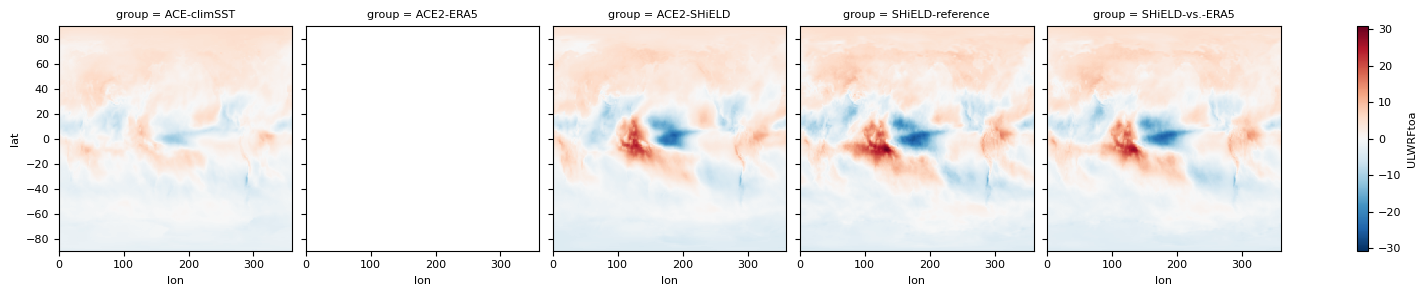

In [85]:
enso_coefficient_ds.ULWRFtoa.sel(duration='10yr', source='prediction').mean('IC').plot(col='group')

In [86]:
enso_coefficient_IC_mean = enso_coefficient_ds.mean('IC')

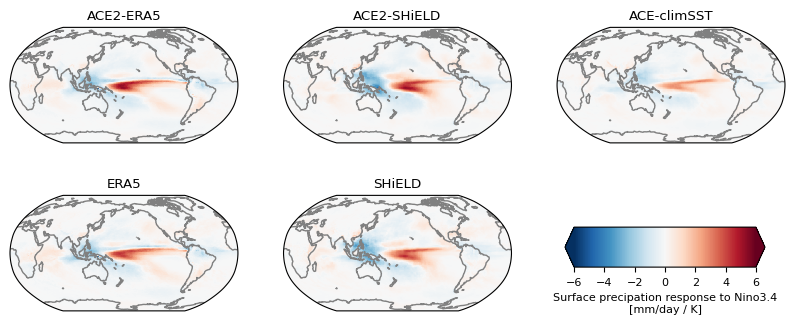

In [87]:
plot_var = 'PRATEsfc'
duration = '81yr'
plot_kwargs = dict(vmin=-6, vmax=6, cmap='RdBu_r')

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
ax0 = axes.flatten()[0]
h = enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ACE2-ERA5'
).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax0.set_title('ACE2-ERA5')
ax1 = axes.flatten()[1]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ACE2-SHiELD'
).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax1.set_title('ACE2-SHiELD')
ax2 = axes.flatten()[2]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ACE-climSST'
).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax2.set_title('ACE-climSST')
ax3 = axes.flatten()[3]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='target', group='ACE2-ERA5'
).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax3.set_title('ERA5')
ax4 = axes.flatten()[4]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='target', group='ACE2-SHiELD'
).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax4.set_title('SHiELD')
[ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
ax5 = axes.flatten()[5]
ax5.set_axis_off()
del ax5
ax5 = fig.add_axes([0.68, 0.25, 0.2, 0.1])
fig.colorbar(
    h, cax=ax5,
    orientation='horizontal',
    extend='both',
    ticks=np.linspace(-6, 6, 7),
    label='Surface precipation response to Nino3.4\n[mm/day / K]'
)
fig.set_size_inches([10, 4])
# fig.savefig(f'enso_coefficient_maps_{plot_var}.png', bbox_inches='tight', facecolor='w')

In [ ]:
plot_var = 'PRATEsfc'
duration = '10yr'
plot_kwargs = dict(vmin=-6, vmax=6, cmap='RdBu_r')

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
ax0 = axes.flatten()[0]
h = enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ACE2-ERA5'
).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax0.set_title('ACE2-ERA5')
ax1 = axes.flatten()[1]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ACE2-SHiELD'
).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax1.set_title('ACE2-SHiELD')
ax2 = axes.flatten()[2]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='prediction', group='ACE-climSST'
).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax2.set_title('ACE-climSST')
ax3 = axes.flatten()[3]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='target', group='ACE2-ERA5'
).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax3.set_title('ERA5')
ax4 = axes.flatten()[4]
enso_coefficient_IC_mean[plot_var].sel(
    duration=duration, source='target', group='ACE2-SHiELD'
).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
ax4.set_title('SHiELD')
[ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
ax5 = axes.flatten()[5]
ax5.set_axis_off()
del ax5
ax5 = fig.add_axes([0.68, 0.25, 0.2, 0.1])
fig.colorbar(
    h, cax=ax5,
    orientation='horizontal',
    extend='both',
    ticks=np.linspace(-6, 6, 7),
    label='Surface precipation response to Nino3.4\n[mm/day / K]'
)
fig.set_size_inches([10, 4])

In [ ]:
# plot_var = 'ULWRFtoa'
# duration = '82yr'
# plot_kwargs = dict(vmin=-5, vmax=5, cmap='RdBu_r')

# fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
# ax0 = axes.flatten()[0]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='ERA5-ACEv2'
# ).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax0.set_title('ERA5-ACEv2')
# ax1 = axes.flatten()[1]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax1.set_title('SHiELD-AMIP-ACEv2')
# ax2 = axes.flatten()[2]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='climSST-ACEv1'
# ).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax2.set_title('climSST-ACEv1')
# ax3 = axes.flatten()[3]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='ERA5-ACEv2'
# ).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax3.set_title('ERA5')
# ax4 = axes.flatten()[4]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax4.set_title('SHiELD-AMIP')
# ax5 = axes.flatten()[5]
# ax5.set_axis_off()
# [ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
# fig.set_size_inches([10, 4])

In [ ]:
# plot_var = 'TMP2m'
# duration = '82yr'
# plot_kwargs = dict(vmin=-5, vmax=5, cmap='RdBu_r')

# fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))
# ax0 = axes.flatten()[0]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='ERA5-ACEv2'
# ).plot(ax=ax0, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax0.set_title('ERA5-ACEv2')
# ax1 = axes.flatten()[1]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax1, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax1.set_title('SHiELD-AMIP-ACEv2')
# ax2 = axes.flatten()[2]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='prediction', group='climSST-ACEv1'
# ).plot(ax=ax2, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax2.set_title('climSST-ACEv1')
# ax3 = axes.flatten()[3]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='ERA5-ACEv2'
# ).plot(ax=ax3, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax3.set_title('ERA5')
# ax4 = axes.flatten()[4]
# enso_coefficient_IC_mean[plot_var].sel(
#     duration=duration, source='target', group='SHiELD-AMIP-ACEv2'
# ).plot(ax=ax4, transform=ccrs.PlateCarree(), add_colorbar=False, **plot_kwargs)
# ax4.set_title('SHiELD-AMIP')
# ax5 = axes.flatten()[5]
# ax5.set_axis_off()
# [ax.coastlines(color='gray') for ax in axes.flatten()[:-1]]
# fig.set_size_inches([10, 4])